# Ground Plane and Obstacle Detection Using Lidar

This example shows how to detect the ground plane and find nearby obstacles in 3-D Lidar data. This process can facilitate drivable path planning for vehicle navigation.

Each scan of Lidar data is stored as a 3-D point cloud. To efficiently process such data, fast indexing and search capability are required. The efficiency is achieved by using a pointCloud object, which internally organizes the data using a k-d tree structure. The ground plane is fitted by the RANSAC algorithm, which is a robust model-fitting method. This example also shows how to use a point cloud player to visualize streaming point cloud data.

## Select a Point Cloud Region for Display

Start by selecting a smaller region around a vehicle and configuring the pcplayer to display it.

Load a sequence of point clouds.

To highlight the environment around the vehicle, concentrate on a region of interest that spans 20 meters to the left and right of the vehicle, and 40 meters in front and back of the vehicle.

In [1]:
d = load('01_city_c2s_fcw_10s_Lidar.mat');
pcloud = d.LidarPointCloud;

pc = pcloud(1).ptCloud;

% Set the region of interest.
xBound  = 40; % in meters
yBound  = 20; % in meters
xlimits = [-xBound, xBound];
ylimits = [-yBound, yBound];
zlimits = pc.ZLimits;

player = pcplayer(xlimits, ylimits, zlimits);

% Crop the point cloud to only contain points within the specified region.
indices = find(pc.Location(:, 2) >= -yBound ...
             & pc.Location(:, 2) <=  yBound ...
             & pc.Location(:, 1) >= -xBound ...
             & pc.Location(:, 1) <=  xBound);

% Select the subset of points and display them.
pc = select(pc, indices);
view(player, pc)

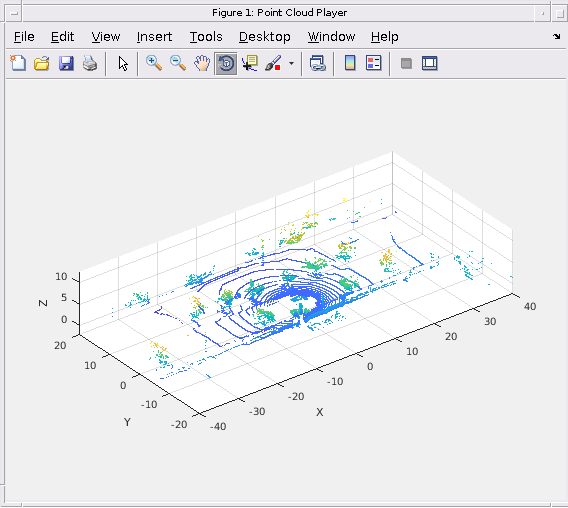

## Segment Ground Plane and Nearby Obstacles

Find the ground plane and remove ground plane points. Use RANSAC algorithm to detect and fit the ground plane. The normal direction of the plane should roughly point upward along the Z-axis. All inlier points must be within 20 cm of the ground plane.

Attach a color label to each point in the point cloud. Use green to show ground plane and red for obstacles that are within 10 meters of the Lidar sensor.

Retrieve points that are within a radius of 10 meters, and label them as obstacles.

In [2]:
maxDistance = 0.2; % in meters
referenceVector = [0, 0, 1];
[~, inPlanePointIndices, outliers] = pcfitplane(pc, maxDistance, referenceVector);

labelSize   = [pc.Count, 1];
colorLabels = zeros(labelSize, 'single');

% Set the colormap for labeling the points.
colors = [0 0 1; ...  % Blue for unlabeled points; specified as [R, G, B]
          0 1 0; ...  % Green for ground plane points
          1 0 0; ...  % Red for obstacle points
          0 0 0];     % Black for ego-vehicle points

blueIdx  = 0; % the entire point cloud is initially blue
greenIdx = 1;
redIdx   = 2;
blackIdx = 3;

% Label the ground plane points.
colorLabels(inPlanePointIndices) = greenIdx;

% Select the points that are not part of the ground plane.
pcWithoutGround = select(pc, outliers);

sensorLocation   = [0,0,0]; % place the Lidar sensor at the center of coordinate system
radius           = 10;      % in meters

nearIndices  = findNeighborsInRadius(pcWithoutGround, sensorLocation, radius);
nearPointIndices = outliers(nearIndices);

% Label the obstacle points.
colorLabels(nearPointIndices) = redIdx;

## Segment the Ego Vehicle

The Lidar is typically mounted on top of the vehicle, and the data may contain points from the vehicle itself, such as the roof and hood. They are the closest points to the Lidar sensor that are not obstacles. Retrieve points within a small radius that encompasses the vehicle. Use use these points to form an axis-aligned bounding cube to represent the ego vehicle.

Form a bounding cube and label the ego-vehicle points.

Plot all labeled points into the point cloud player. Use the numeric color labels that we set up earlier.

In [3]:
radius      = 3; % in meters
nearIndices = findNeighborsInRadius(pcWithoutGround, sensorLocation, radius);

vehiclePointIndices = outliers(nearIndices);
pcVehicle           = select(pcWithoutGround, nearIndices);

delta = 0.1;
selfCube = [pcVehicle.XLimits(1)-delta, pcVehicle.XLimits(2)+delta ...
            pcVehicle.YLimits(1)-delta, pcVehicle.YLimits(2)+delta ...
            pcVehicle.ZLimits(1)-delta, pcVehicle.ZLimits(2)+delta];

colorLabels(vehiclePointIndices) = blackIdx;

colormap(player.Axes, colors)
view(player, pc.Location, colorLabels);
title(player.Axes, 'Segmented Point Cloud');

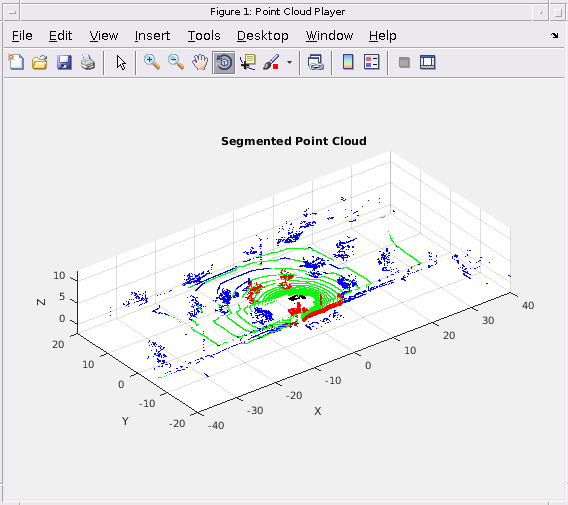

## Process the Point Cloud Sequence

Now that we have the point cloud player configured and the process for labeling the point cloud with color labels established, let's process the entire point cloud sequence.

In [4]:
for k = 2:length(pcloud)
    pc = pcloud(k).ptCloud;

    % Crop the data to ROI.
    indices = find(pc.Location(:, 2) >= -yBound ...
                 & pc.Location(:, 2) <=  yBound ...
                 & pc.Location(:, 1) >= -xBound ...
                 & pc.Location(:, 1) <=  xBound);
    pc = select(pc, indices);

    colorLabels = zeros(pc.Count, 1, 'single'); % create label array

    % Fit the ground plane.
    [~, inPlanePointIndices, outliers] = pcfitplane(pc, maxDistance, referenceVector);
    colorLabels(inPlanePointIndices) = greenIdx;

    pcWithoutGround = select(pc, outliers);

    % Find the points corresponding to obstacles
    radius           = 10; % in meters
    nearIndices      = findNeighborsInRadius(pcWithoutGround, sensorLocation, radius);
    nearPointIndices = outliers(nearIndices);

    colorLabels(nearPointIndices) = redIdx;

    % Find the ego-vehicle points.
    nearIndices         = findPointsInROI(pcWithoutGround, selfCube);
    vehiclePointIndices = outliers(nearIndices);

    colorLabels(vehiclePointIndices) = blackIdx;

    % Plot the results.
    view(player, pc.Location, colorLabels);
end

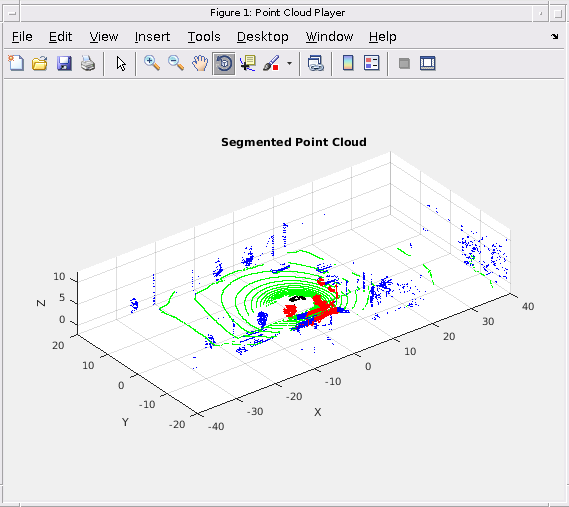